In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import namedtuple, deque
from tqdm import tqdm
%matplotlib inline
import gym
from datetime import datetime
import pandas as pd  
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import itertools


In [2]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
    
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
device = torch.device("cpu")

class ReplayBuffer:

    def __init__(self, state_size, action_size, buffer_size, batch_size, priority=False):
        self.states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.next_states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=float)
        
        self.priority = priority

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        
        self.actions[self.ptr] = torch.from_numpy(np.asarray(action)).to(device)
        self.rewards[self.ptr] = torch.from_numpy(np.asarray(reward)).to(device)
        self.dones[self.ptr] = done
#         self.actions[self.ptr] = action
#         self.rewards[self.ptr] = reward
#         self.dones[self.ptr] = done
        
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        """Randomly sample a batch of experiences from memory."""
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        # else:
        if self.priority:
            idx = np.random.choice(n, self.batch_size, replace=False, p=self.e)
        else:
            idx = np.random.choice(n, self.batch_size, replace=False)
        
        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        
        return (states, actions, rewards, next_states, dones), idx
      
    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        e = e / e.sum()
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()
        
    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

In [4]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

In [5]:
class DDQNAgent():
    def __init__(self, state_size, action_size, seed=42, model_type='DQN'):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.model_type = model_type

       
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences, idx = self.memory.sample()
                e = self.learn(experiences)
                self.memory.update_error(e, idx)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
          
    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            if self.model_type:
                old_val = self.qnetwork_local(states).gather(-1, actions)
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                target = rewards+GAMMA*maxQ*(1-dones)
            else:
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        self.optimizer.zero_grad()
        if self.model_type:
            old_val = self.qnetwork_local(states).gather(-1, actions)
            with torch.no_grad():
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                target = rewards+GAMMA*maxQ*(1-dones)
        else:
            with torch.no_grad():
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)   
        
        loss = F.mse_loss(old_val, target)
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
        return old_val - target


    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [6]:
ls=['DQN', 'DDQN', 'Priority']
envs='LunarLander-v2'
n_episodes=20
max_t=20
eps_start=1.0
eps_end=0.01
eps_decay=0.995

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.63it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_30716\3412818337.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figs.show()


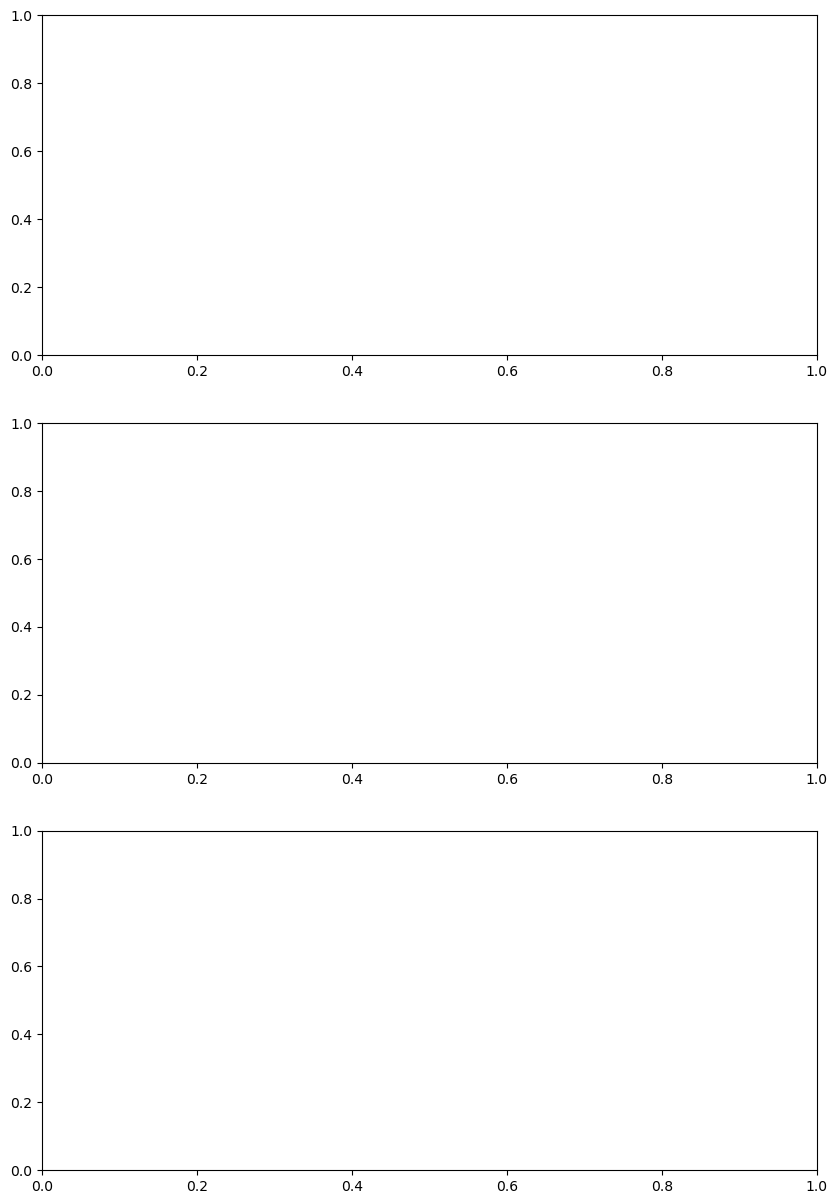

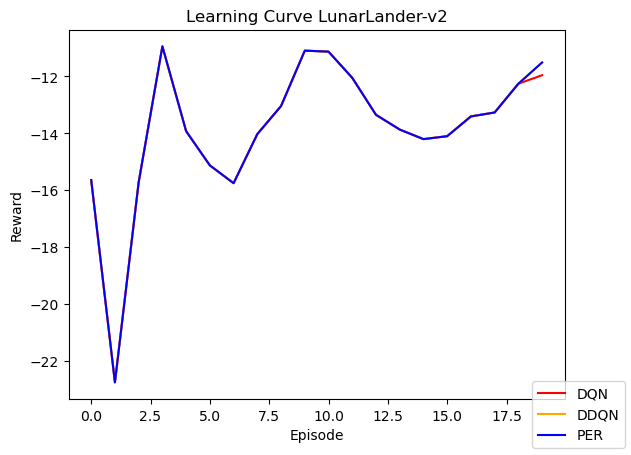

In [7]:
res = []

for j in ls:
    rewards = []
    aver_reward = []
    aver = deque(maxlen=100)
    loss_history_policy = []
    loss_history_value = []
    
    env = gym.make(envs)
    env.seed(0)
    
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DDQNAgent(state_size, action_size, 1, model_type='DDQN')
    eps = eps_start
    
    for i_episode in tqdm(range(1, n_episodes + 1)):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        aver.append(score)     
        aver_reward.append(np.mean(aver))
        rewards.append(score)
        eps = max(eps_end, eps_decay * eps)  # Decrease epsilon
        
    reward="model/"+envs+""+j[2]+""+str(n_episodes)+"_"+str(datetime.now().strftime("%Y%m%d%H%M%S"))
    torch.save(agent.qnetwork_local.state_dict(),reward+'.pt')
    res.append(aver_reward)

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
figs = plt.figure()

reward='plots/'+envs+'_result'+str(datetime.now().strftime("%Y%m%d%H%M%S"))
df=pd.DataFrame({'DQN':res[0],'DDQN':res[1],'Priority':res[2]})
df.to_csv(reward+'.csv')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df['DQN'], 'r', label='DQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df['DDQN'], 'orange',label='DDQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df['Priority'],'b',label='PER')
    
plt.title('Learning Curve '+envs)

figs.legend(loc='lower right')
figs.savefig(reward+'.png', dpi=100)
figs.show()